# N-Queens problem with Genetic Algorithms
### Spencer Hann

## Main build

In [1]:
%load_ext Cython
%matplotlib notebook

In [5]:
%%cython
# cython: language_level=3, boundscheck=False

from libc.stdlib cimport rand, RAND_MAX
from tqdm import tqdm
from matplotlib import pyplot as plt
from pandas import DataFrame
import sys
import numpy as np
cimport numpy as np
ctypedef np.ndarray nparray

DEF LIVE_PLOT = 1 # live plot displays population mean in real-time during training

cdef ssize_t board_dim = 8
cdef int max_fitness = board_dim * (board_dim-1) // 2

cdef class ChessBoard:
    cdef public int[::1] queens
    
    def __cinit__(ChessBoard self):
        # each value represents the row of a queen,
        # queens are fixed to a column.
#         self.queens = np.random.randint(0,board_dim, size=board_dim, dtype=np.intc)
        self.queens = np.arange(board_dim, dtype=np.intc)
        np.random.shuffle(self.queens)
    
    @classmethod
    def from_parents(cls, ChessBoard parent0, ChessBoard parent1):
        return cls().reproduce(parent0, parent1)
    
    cdef void reproduce(ChessBoard self, ChessBoard parent0, ChessBoard parent1):
        cdef ssize_t split = rand() % board_dim
        self.queens[:split] = parent0.queens[:split]
        self.queens[split:] = parent1.queens[split:]
        
    cdef void mutate(ChessBoard self):
        cdef ssize_t i = rand() % board_dim # which queen to mutate
        self.queens[i] = rand() % board_dim # move to random row
        
    cdef void smart_mutate(ChessBoard self):
#         cdef ssize_t i, j # row, column
#         cdef int error = 0
#         cdef int[::1] q = self.queens

#         for i in range(board_dim):
#             for j in range(i+1,board_dim):
#                 # compare row distance to column distance
#                 if abs(q[i] - q[j]) == abs(i - j):
#                     q[j] = rand() % board_dim
#                 elif q[i] == q[j]:
#                     q[j] = rand() % board_dim
        cdef ssize_t i = rand() % board_dim # which queen to mutate
        cdef int tmp = 0
        self.queens[i] = -1
        while tmp in self.queens and tmp <= board_dim:
            tmp += 1
        if tmp == board_dim: tmp = rand() % board_dim
        self.queens[i] = tmp
        
    cdef int fitness(ChessBoard self):
        cdef ssize_t i, j # row, column
        cdef int error = 0
        cdef int[::1] q = self.queens

        for i in range(board_dim):
            for j in range(i+1,board_dim):
                # compare row distance to column distance
                if abs(q[i] - q[j]) == abs(i - j):
                    error += 1 # same diagonal
                elif q[i] == q[j]:
                    error += 1 # same row

        return max_fitness - error
#         return 1 - error / max_fitness # for fitness as float in range [0,1]

    def display(self, n_iterations=None):
        cdef ssize_t i, j
        cdef nparray board = np.empty((board_dim,board_dim), dtype=str)
        board.fill('.')
        
        print("\tFitness",self.fitness(),'/',max_fitness,end=' ')
        if n_iterations:
            print(f"after {n_iterations} iterations")
        print() # new line
        
        for i in range(board_dim):
            for j in range(board_dim):
                if i%2 == j%2:
                    board[j,i] = '-'
            board[self.queens[i], i] = 'Q'
        print(DataFrame(board))

cdef void normalize(int[::1] vector, double[::1] normalized_vector):
    cdef ssize_t i
    cdef int threshold = np.mean(vector)
    cdef int total = 0
    
    for i in range(vector.shape[0]):
        total += vector[i]
        
    for i in range(vector.shape[0]):
        normalized_vector[i] = vector[i] / total

cdef void harsh_normalize(int[::1] vector, double[::1] normalized_vector, double threshold):
    cdef ssize_t i
    cdef int total = 0
    
    for i in range(vector.shape[0]):
        if vector[i] >= threshold: total += vector[i]
        
    for i in range(vector.shape[0]):
        if vector[i] < threshold: normalized_vector[i] = 0
        else: normalized_vector[i] = vector[i] / total
    
cdef void population_fitness(int[::1] fitness, object[::1] population, double[:] progress):
    for i in range(fitness.shape[0]):
        fitness[i] = (<ChessBoard>population[i]).fitness()
        if fitness[i] > progress[1]:
            progress[1] = fitness[i]

    progress[0] = np.mean(fitness)
    progress[2] = np.std(fitness)
    
def GeneticAlgorithm(ssize_t board_size=8,
                     int population_size=1000,
                     int n_iterations=1000,
                     double mutation_chance=0.02):
    cdef:
        object[::1] population = np.ndarray(population_size, dtype=ChessBoard)
        object[::1] new_population = np.ndarray(population_size, dtype=ChessBoard)
        object[::1] tmp # for swapping, saves time on copying/new initializations
        object[::1] states = np.ndarray(n_iterations, dtype=ChessBoard)
        int[::1] fitness = np.ones(population_size, dtype=np.intc)
        double[::1] weights = np.empty(population_size, dtype=np.float_)
        double[:,::1] progress = np.zeros((3,n_iterations), dtype=np.float_)
        ChessBoard x, y
        ssize_t i, n
        int index
        int mutation_threshold = <int>(RAND_MAX * mutation_chance)
        double _mutation_chance = mutation_chance
        
    # setup utility globals
    global board_dim, max_fitness
    board_dim = board_size
    max_fitness = board_dim * (board_dim-1) // 2
    
    
    for i in range(population_size):
        population[i] = ChessBoard()
        new_population[i] = ChessBoard()
        states[i] = ChessBoard()
    for i in range(population_size,n_iterations):
        states[i] = ChessBoard()

    print(f"board size: {board_dim}x{board_dim}")
    print("goal fitness:",max_fitness)
    sys.stdout.flush()
    
    IF LIVE_PLOT: # setup live plot
        fig, (ax, axstd) = plt.subplots(nrows=2,ncols=1,sharex=True)#,figsize=(14, 10))
        plt.ion()
        ax.clear(); axstd.clear()
        ax.grid(True); axstd.grid(True)
        fig.show()
        fig.canvas.draw()

    for n in (range(n_iterations)):
        
        # store best of every generation
        index = np.argmax(fitness)
        states[n].queens[:] = population[index].queens[:]
        
        # normal vs. aggressive selection/mutation
        # evolve agressively if mean or std fitness falls below threshold
        if rand()%4 or progress[0,n-1] < max_fitness-2 or progress[1,n-1] < 0.1:
#         if progress[0,n-1] < .985 * max_fitness or progress[1,n-1] < 0.1:
            harsh_normalize(fitness,weights,progress[0,n-1])
            mutation_chance = _mutation_chance * 2
        else:
            normalize(fitness, weights)
            mutation_chance = _mutation_chance

        # breed new generation
        for i in range(population_size):
            x, y = np.random.choice(population, size=2, p=weights)
            (<ChessBoard>new_population[i]).reproduce(x, y)
            
            # mutate?
            if rand() < mutation_threshold:
                if rand() % 4: # allow true random mutation some of the time
                    (<ChessBoard>new_population[i]).smart_mutate()
                else:
                    (<ChessBoard>new_population[i]).mutate()
        
        # swap main populatin w/ new generation
        tmp = population
        population = new_population
        new_population = tmp
        
        #calculate new generation's fitness and store progress
        population_fitness(fitness, population, progress[:,n])

        IF LIVE_PLOT: # update live plot
            if n % 20 == 0 or progress[1,n] == max_fitness:
                ax.clear(); axstd.clear()
                ax.plot(progress[1,:n+1],'.', label="best fitness of generation", markersize=4)
                ax.plot(progress[0,:n+1], label="mean fitness of generation")
                axstd.plot(progress[2,:n+1], label="standard deviation")
                ax.legend(); axstd.legend()
                ax.grid(True); axstd.grid(True)
                fig.canvas.draw()
        
        if progress[1,n] == max_fitness:
            n += 1
            states = states[:n+1]
            progress = progress[:,:n+1]
            break
    
    # store last best
    index = np.argmax(fitness)
    states[n].queens[:] = population[index].queens[:]
    
    print("final fitness:",fitness[index],'/',max_fitness)
    print(f"in {n+1} generations")
    return states, progress

## Code Summary

When I began writing this program, I realized I did not need to store states as whole boards (a matrix of 0's with 1's for Queens). I could simply store the queens a list of locations. After working on it a little longer I realize that, while this saved memory, I could implement the states even better. I "fixed" each queen to a column and only allowed for row-wise movement, which is not only a better way to track states it reduces the state-space significantly, only excluding illegal states. This was my first major optimization.  

With the queens each fixed to a column I update the `mutate` function to select a queen at random, then randomize that queen's row. I then tried implementing a more useful version, `smart_mutate`, which selects a queen at random, then searches for and "open" row and places the queen there. This made an improvement, but not as much as I thought it would.

One of the most significant optimizations I made, was to implement `harsh_normalize`. Unlike `normalize`, which takes a vector(presumably the fitness vector) and normalizes it, `harsh_normalize` normalizes the input vector across all elements greater than that vectors mean, and sets all other elements to 0. The ouput normalized vectors are used as the selection probabilities for the reproduction phase. The effect that this has is that only states with above average fitness are allowed to be combined into the new generation.  

Most of the time the `normalize` function is used to create selection probabilities. However, if the population mean is below a certain threshold (about 98.5% of the `max_fitness`), or the standard deviation of the current generations fitness (a measure of diversity) falls below a certain threshold, `harsh_normalize` is used, and the probability of a mutation occuring is also doubled for that generation. This makes the evolution process more aggressive if the population is under-performing (overall poor fitness) or stagnating (losing diversity).

## Testing

In [ ]:
def display_board_progress(boards):
    n = boards.shape[0]
    step = n // 4
    if step != 0: # sometimes solves in less than 4 generations
        for i in range(0,n-1,step):
            print("\nBest state in generation",i+1)
            boards[i].display(n_iterations=i+1)
    
    print("\nFinal state:",n)
    boards[-1].display(n_iterations=n)

### 8x8 board, 8 Queens

In [ ]:
%time boards, progress = GeneticAlgorithm(board_size = 8, \
                                          population_size=500, \
                                          n_iterations=1000, \
                                          mutation_chance=0.02)

In [ ]:
display_board_progress(boards)

### 12 Queens

In [ ]:
%time boards, progress = GeneticAlgorithm(board_size = 12, \
                                          population_size=1000, \
                                          n_iterations=1000, \
                                          mutation_chance=0.02)

### 16 Queens

In [ ]:
%time boards, progress = GeneticAlgorithm(board_size = 16, \
                                          population_size=2000, \
                                          n_iterations=2500, \
                                          mutation_chance=0.02)

In [ ]:
display_board_progress(boards)

### 20 Queens

In [ ]:
%time boards, progress = GeneticAlgorithm(board_size = 20, \
                                          population_size=2500, \
                                          n_iterations=2500, \
                                          mutation_chance=0.02)

In [ ]:
boards[-1].display(n_iterations=len(boards)+1)

The boards are getting pretty big so, I'll just display the final solution.

board size: 50x50
goal fitness: 1225


<IPython.core.display.Javascript object>


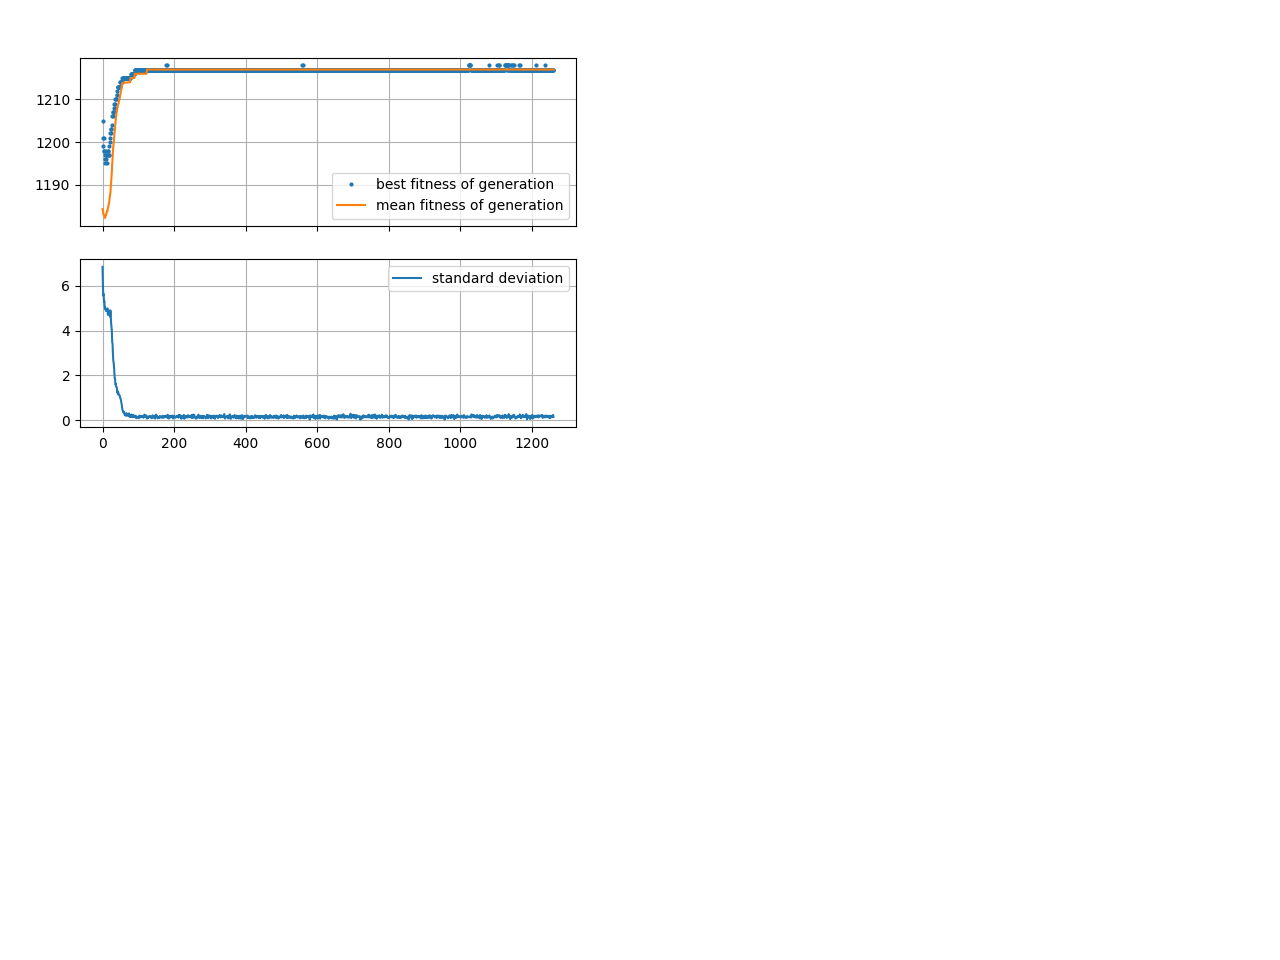

In [ ]:
%time boards, progress = GeneticAlgorithm(board_size = 50, \
                                          population_size=1000, \
                                          n_iterations=5000, \
                                          mutation_chance=0.02)

In [ ]:
%time boards, progress = GeneticAlgorithm(board_size = 50, \
                                          population_size=1000, \
                                          n_iterations=5000, \
                                          mutation_chance=0.02)